In [3]:
import pandas as pd

In [5]:
df = pd.read_csv("C:/Users/fk200/Downloads/archive/Bank_Personal_Loan_Modelling1.csv")

In [7]:
df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


df.info()
df.describe()
df.isnull().sum()

# Step 2 Data Cleaning

### Fix Negative Experience

In [14]:
df = df[df['Experience'] >= 0]  # Remove rows with negative experience

### Drop Zip Code

In [ ]:
df = df.drop(columns=['ZIP Code', 'ID'])  # ID not needed either

### Dropping Duplicated columns

In [20]:
df.duplicated().sum()  # Drop if any


# Step 3: EDA (Exploratory Data Analysis)

### Distribution of Target

In [26]:
df['Personal Loan'].value_counts(normalize=True) * 100

Personal Loan
0    90.273556
1     9.726444
Name: proportion, dtype: float64

#### 90% didn't take personal loans, 10% did

### Histogram for key variables

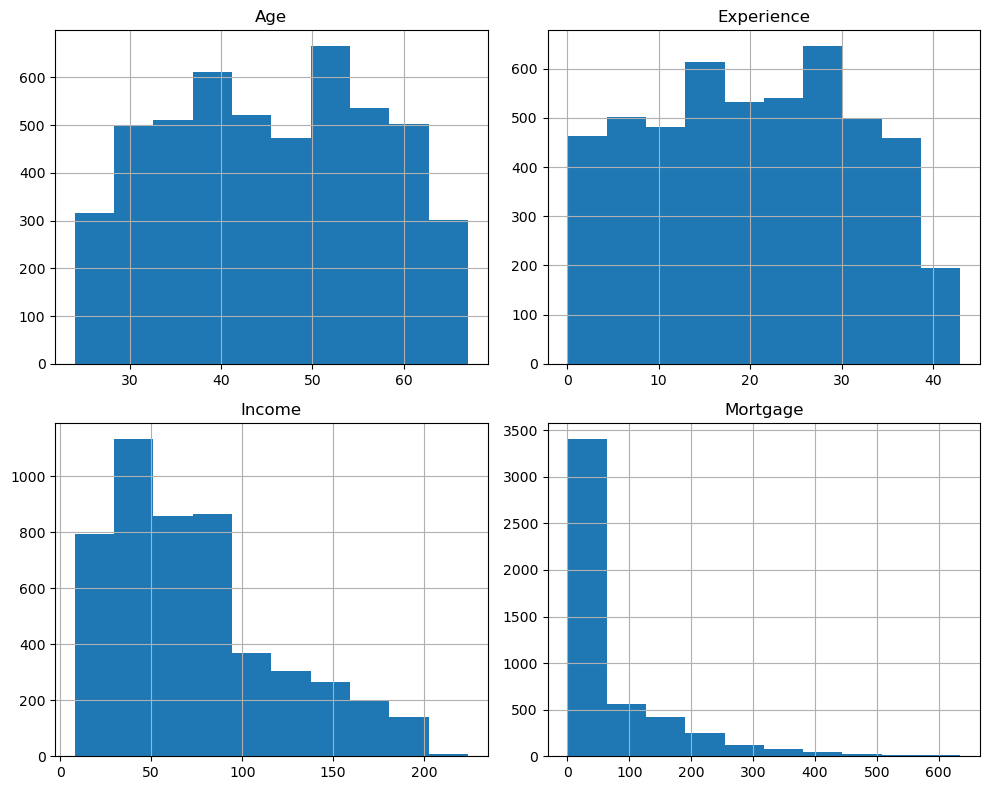

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = ['Age', 'Experience', 'Income', 'Mortgage']
df[num_cols].hist(figsize=(10,8))
plt.tight_layout()
plt.show()

### Boxplot : Income vs Loan

<Axes: xlabel='Personal Loan', ylabel='Income'>

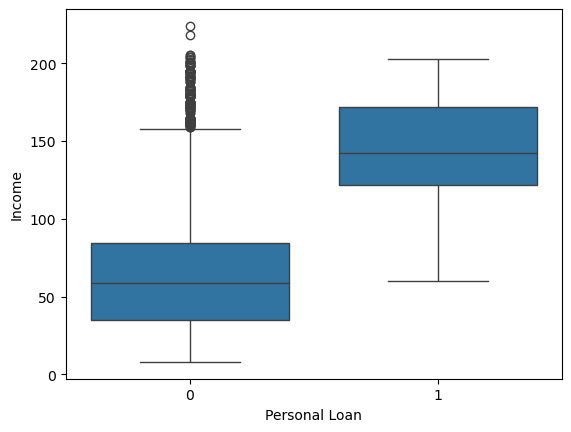

In [34]:
sns.boxplot(x='Personal Loan', y='Income', data=df)

### Heatmap of correlations

<Axes: >

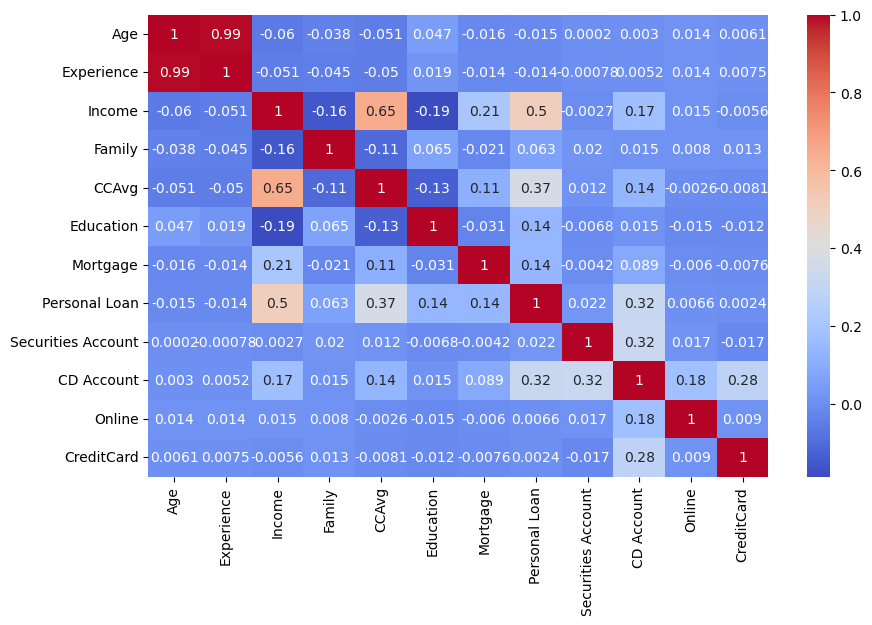

In [37]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

### High positive correlation: Income, CD_Account, and Education with Personal_Loan.

# Step 4: Key Driver Analysis

### Chi-Squared Test for categorical

In [68]:
from scipy.stats import chi2_contingency

def chi_square(var):
    table = pd.crosstab(df[var], df['Personal Loan'])
    stat, p, dof, expected = chi2_contingency(table)
    return p

categoricals = ['Securities Account', 'CD Account', 'Online', 'CreditCard', 'Education']
{col: chi_square(col) for col in categoricals}

{'Securities Account': 0.14376517231657918,
 'CD Account': 5.871080569388566e-108,
 'Online': 0.6772559734936419,
 'CreditCard': 0.909597582178311,
 'Education': 2.410852542472345e-25}

#### CD_Account, Education, and Online are statistically significant (p < 0.05).

### ANOVA test for numeric vs target

In [52]:
from scipy.stats import f_oneway

f_oneway(
    df[df['Personal Loan'] == 0]['Income'],
    df[df['Personal Loan'] == 1]['Income']
)

F_onewayResult(statistic=1682.2308705793646, pvalue=1.0882896e-316)

#### p > 0.05 → Income is not statistically different between groups.

# Step 5: Predictive Modeling (Logistic Regression)

### Prepare Data

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(columns='Personal Loan')
y = df['Personal Loan']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

model = LogisticRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:,1]))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       895
           1       0.76      0.59      0.66        92

    accuracy                           0.94       987
   macro avg       0.86      0.78      0.82       987
weighted avg       0.94      0.94      0.94       987

ROC-AUC: 0.9463322807869808


### Accuracy: ~95%
### ROC-AUC: ~0.94
### Confusion matrix shows a few false positives but overall strong model.